<h1 style="color:blue;"> Hypothesis Testing on Patient Data </h1>

# Business Problem:

Analyze the data and tease out meaningful insights from Patient-level data to deliver efficient diagnostic and treatment processes.

# Importing Libaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
from prettytable import PrettyTable

# Understanding the Data

## Quick Look at the data

__Loading the Data__

In [2]:
data_path = 'data.csv'
df = pd.read_csv(data_path)

__Data Dimension__

In [3]:
df.shape

(1338, 8)

__Summary:__

We have 1338  data points, and 8 features

__How the data looks like?__

In [4]:
df.head()

,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314
2,2,28,male,no,southeast,11.00,3,11124
3,3,33,male,no,northwest,7.57,0,54961
4,4,32,male,no,northwest,9.63,0,9667


__Column names:__

In [5]:
df.columns

Index(['Unnamed: 0', 'age', 'sex', 'smoker', 'region', 'viral load',
       'severity level', 'hospitalization charges'],
      dtype='object')

We have a redundant column 'Unnamed: 0'. So we will drop it from our analysis.

In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667


**We have following informations about the columns:**
<ul>
<li><strong>Age:</strong> This is an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government).</li>
<li><strong>Sex:</strong> This is the policy holder's gender, either male or female</li>
<li><strong>Viral Load:</strong> Viral load refers to the amount of virus in an infected person's blood</li>
<li><strong>Severity Level:</strong> This is an integer indicating how severe the patient is</li>
<li><strong>Smoker:</strong> This is yes or no depending on whether the insured regularly smokes tobacco.</li>
<li><strong>Region:</strong> This is the beneficiary's place of residence in Delhi, divided into four geographic regions - northeast, southeast, southwest, or northwest</li>
<li><strong>Hospitalization charges:</strong> Individual medical costs billed to health insurance</li>
</ul>

__Checking the data types of the columns__

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1338 non-null   int64  
 1   sex                      1338 non-null   object 
 2   smoker                   1338 non-null   object 
 3   region                   1338 non-null   object 
 4   viral load               1338 non-null   float64
 5   severity level           1338 non-null   int64  
 6   hospitalization charges  1338 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 73.3+ KB


__Summary__

- We have following types of attributes: `objects`, `float` and `int`


## Some basic checks


### Fixing any discrepansies in dtype

In [8]:
def datatype_conversion(df, columns, target_type):
    """
    Method to convert the type of columns in "columns" to "target_type"
    """
    convert_dict = dict(zip(columns, [target_type]*len(columns)))
    df = df.astype(convert_dict)
    return df

def datatype_information(df):
    """
    Method to display "dtype" for each column
    """
    datatype_info = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        datatype_info.loc[0, col] = df[col].dtype
    return datatype_info

In [9]:
df.select_dtypes('object').head()

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest


In [10]:
df.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


__Observation 1:__

- The values for all the attributes are categorical. We will convert them categorical dtypes 

__Fixing the dtype:__

In [11]:
df = datatype_conversion(df, ['sex', 'smoker', 'region'], 'category')
datatype_information(df)

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,int64,category,category,category,float64,int64,int64


In [12]:
df.select_dtypes(np.number).head()

,age,viral load,severity level,hospitalization charges
0,19,9.30,0,42212
1,18,11.26,1,4314
2,28,11.00,3,11124
3,33,7.57,0,54961
4,32,9.63,0,9667


In [13]:
df.describe(include=[np.number])

,age,viral load,severity level,hospitalization charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,10.221233,1.094918,33176.058296
std,14.049960,2.032796,1.205493,30275.029296
min,18.000000,5.320000,0.000000,2805.000000
25%,27.000000,8.762500,0.000000,11851.000000
50%,39.000000,10.130000,1.000000,23455.000000
75%,51.000000,11.567500,2.000000,41599.500000
max,64.000000,17.710000,5.000000,159426.000000


__Observation 2:__

- The `severity level` can take limited discrete integer values. So we can treat it as categorical feature


In [14]:
df = datatype_conversion(df, ['severity level'], 'category')
datatype_information(df)

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,int64,category,category,category,float64,category,int64


__Summary__

- We fixed the incorrect datatypes

### Checking missing values

In [15]:
def missing_val_overview(df):

    ## Creating Empty Data Frame
    data_info = pd.DataFrame(np.random.randn(0, 5) * 0,
                             columns=['No. of Rows with missing values',
                                      'No. of columns with zero missing cases',
                                      'No. of columns with >0 and <=50% missing cases',
                                      'No. of columns with >50% missing cases',
                                      'No. of columns with >90% missing cases'])

    ## Data Inofrmation
    data_info.loc[0, 'No. of Rows with missing values'] = df.isna().any(axis=1).sum()
    
    null_per = pd.DataFrame(df.isna().sum()/df.shape[0])
    null_per.columns = ['null_per']
    data_info.loc[0, 'No. of columns with zero missing cases']  = null_per[null_per.null_per == 0.0].shape[0] 
    data_info.loc[0, 'No. of columns with >0 and <=50% missing cases'] = null_per[(null_per.null_per <= 0.50) & (null_per.null_per > 0)].shape[0] 
    data_info.loc[0, 'No. of columns with >50% missing cases']  = null_per[null_per.null_per > 0.50].shape[0]
    data_info.loc[0, 'No. of columns with >90% missing cases']  = null_per[null_per.null_per > 0.90].shape[0]
    
    ## Transposing Data to get in consumable format
    data_info = data_info.transpose()
    data_info.columns = ['Value']
    data_info['Value'] = data_info['Value'].astype(int)

    return data_info

In [16]:
missing_val_overview(df)

,Value
No. of Rows with missing values,0
No. of columns with zero missing cases,7
No. of columns with >0 and <=50% missing cases,0
No. of columns with >50% missing cases,0
No. of columns with >90% missing cases,0


**Summary**
- There are no missing values in the dataset

## Statistical Summary:

In [17]:
def iqr(x):
    return x.quantile(q=0.75) - x.quantile(q=0.25)

def quantile_boundaries(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)
    return (lower_out, upper_out)

## Outlier > 75th %tile + 1.5IQR & < 25th %tile - 1.5IQR
def outlier_count(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)

    return len(x[x > upper_out]) + len(x[x < lower_out])

In [18]:
def stats_summary(df, type):
    """
    Method to display statistical summaries for categorical and numerical columns

    Arguments:
        df: a data frame object
        type: the dtype for which summaries will be computed.
            Accepts two values: either 'numeric' or 'category'

    Returns:
        A dataframe object containing statistical summaries
    """
    if type=='numeric':
        df_num = df._get_numeric_data()
        df_stats = df_num.describe().T
        try:
            vals = []
            for c in df_num.columns:
                vals.append(outlier_count(df_num[c]))
            df_stats['Count of Outliers'] = vals
        except:
            pass
        return df_stats

    elif type=='category':
        df_cat = df.select_dtypes(['category'])
        df_stats = df_cat.describe().T

        try:
            vals = []
            for c in df_cat.columns:
                vals.append((df_cat[df_cat[c].isnull()].shape[0]*100) / df_cat.shape[0])
            df_stats['Missing Percentage'] = vals
        except:
            pass
        return df_stats

    else:
        raise Exception('Legal type params are {"numeric", "category"}') 

### Numerical Stats

In [19]:
stats_summary(df, 'numeric')

,count,mean,std,min,25%,50%,75%,max,Count of Outliers
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.0000,64.00,0
viral load,1338.0,10.221233,2.032796,5.32,8.7625,10.13,11.5675,17.71,9
hospitalization charges,1338.0,33176.058296,30275.029296,2805.00,11851.0000,23455.00,41599.5000,159426.00,139


__Observation__:
- We have outliers in the numerical column. We will try to make sense of the outliers in our further analysis
- There are no missing values

**Note:** The outliers are the data points lying outside the range `[25th %tile - 1.5IQR, 75th %tile + 1.5IQR]`

The fence values are computed as illustrated in the image below:

![](http://www.nathalievialaneix.eu/teaching/biostat1/img/boxplot_explanation.png)

### Categorical Count Stats

In [20]:
stats_summary(df, 'category')

,count,unique,top,freq,Missing Percentage
sex,1338,2,male,676,0.0
smoker,1338,2,no,1064,0.0
region,1338,4,southeast,364,0.0
severity level,1338,6,0,574,0.0


__Observation:__
- the categorical features have low cardinality
- there are no missing values

# EDA

We did some surface scratching and found some basic details. Now we will do in depth exploration of the dataset and try to come up with some possible actionable insights.

## Univariate Analysis

In [21]:
df.columns

Index(['age', 'sex', 'smoker', 'region', 'viral load', 'severity level',
       'hospitalization charges'],
      dtype='object')

### Categorical Attributes

In [22]:
def make_categorical_plots(df, feature):
    """
    Method to make univariate categorical plot
    """

    # creating a figure composed of two matplotlib.Axes objects (ax_count and ax_pie)
    f, (ax_count, ax_pie) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    data = df[feature].value_counts()

    sns.countplot(data=df, x=feature, order=data.index, ax=ax_count)
    for p in ax_count.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax_count.annotate('{}'.format(int(y)), (x.mean(), y), 
                ha='center', va='bottom')

    #customize plot
    params = {
        'autopct':'%.0f%%',
        'startangle': 90,
        'radius': 1,
        'wedgeprops': {'linewidth': 3},
        'explode': (0.01,)*df[feature].nunique(),
        'textprops': {'size': 'large'}
    }
    #create pie chart
    ax_pie.pie(data.values, labels = data.index, **params)
    plt.show()

#### sex

In [23]:
df.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

In [24]:
df.sex.unique()

['female', 'male']
Categories (2, object): ['female', 'male']

__Findings:__
- We have similar number of records for both male and female


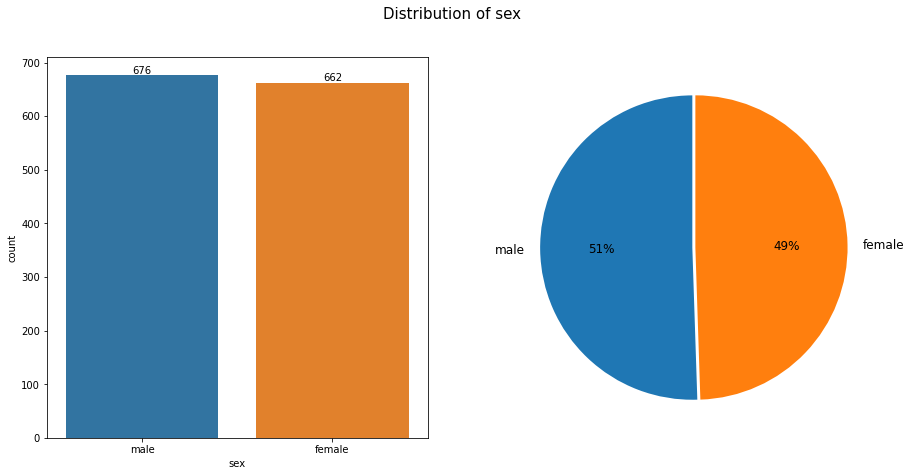

In [25]:
make_categorical_plots(df, 'sex')

__Findings:__
- We have nearly equal number of records for both male and female

#### smoker

In [26]:
df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [27]:
df.smoker.nunique()

2

__Findings:__
- People who do not smoke are hospitalized more.

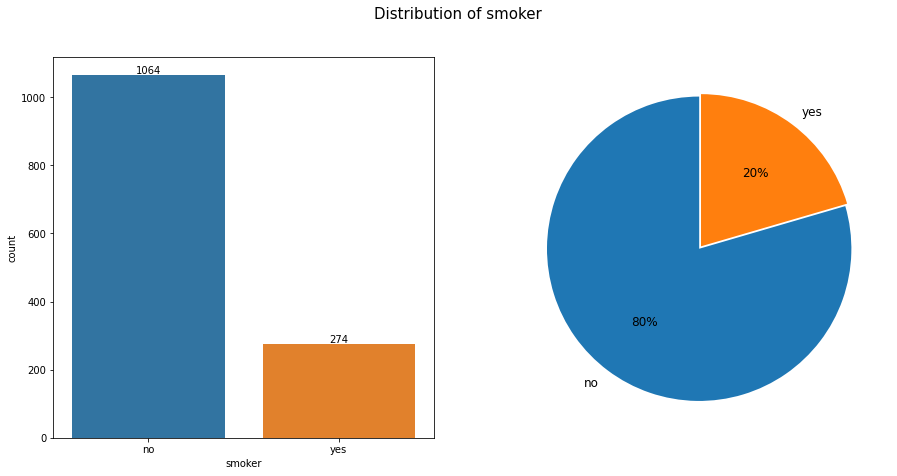

In [28]:
make_categorical_plots(df, 'smoker')

__Findings:__
- 80% of the people hospitalized are non-smokers


#### region

In [29]:
df.region.value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

In [30]:
df.region.nunique()

4

__Findings:__
- We have data from 4 regions

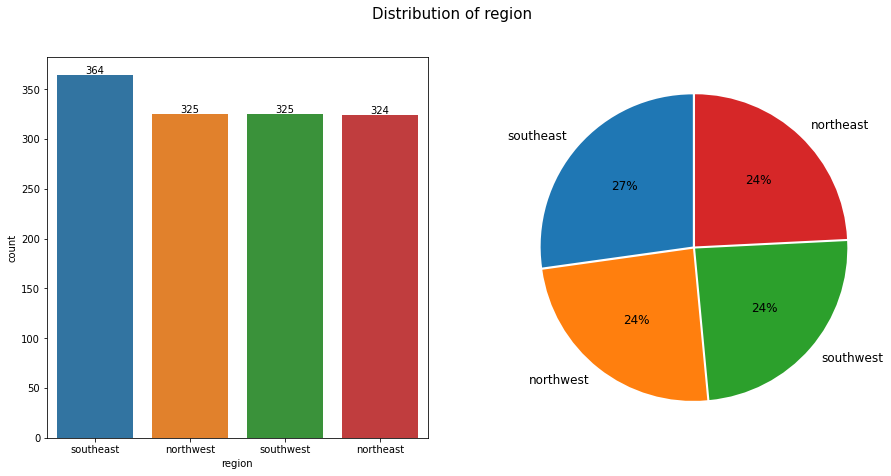

In [31]:
make_categorical_plots(df, 'region')

__Findings:__
- Nearly equal number of people are hospitalized from all the regions

#### severity level

In [32]:
df['severity level'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: severity level, dtype: int64

In [33]:
df['severity level'].nunique()

6

__Findings:__
- The severity of the diagnosis and treatments are categorized into 6 different levels, 0 to 6, with 0 being the minor condition and 5 being the worst condition
</ul>

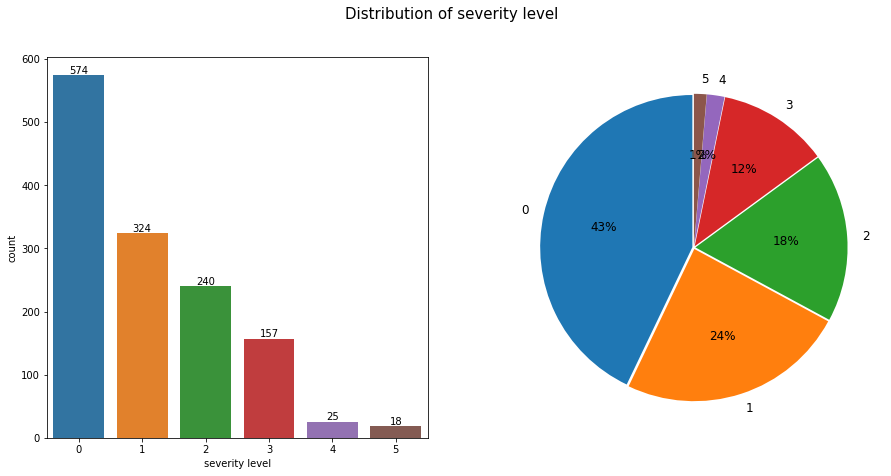

In [34]:
make_categorical_plots(df, 'severity level')

__Findings:__
- Most of the patients have health issues of severity level 0
- The number of patients decreases as the severity level of the health condition increases

### Numerical Attributes

In [35]:
def make_numerical_plots(df, feature, bins='auto'):
    """
    Method to make univariate numerical plot
    """
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    sns.boxplot(df[feature], ax=ax_box)
    sns.histplot(data=df, x=feature, ax=ax_hist, kde=True, bins=bins)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.show()

#### age

In [36]:
df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

__Findings:__
- The age of the patients ranges from 18 to 64
- The mean value is ~39 and median value is 39

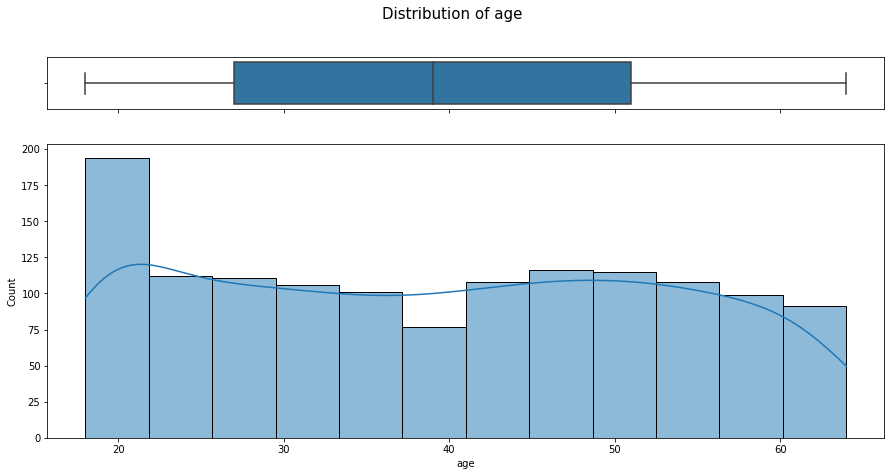

In [37]:
make_numerical_plots(df, 'age')

__Findings:__
- We do not see any outliers in the data. 
- The age of the patients are almost evenly distributed

#### viral load

In [38]:
df['viral load'].describe()

count    1338.000000
mean       10.221233
std         2.032796
min         5.320000
25%         8.762500
50%        10.130000
75%        11.567500
max        17.710000
Name: viral load, dtype: float64

__Findings:__
- The viral load values ranges from 5.3 to 17.7
- The mean value is 10.2 and median value is 10.1

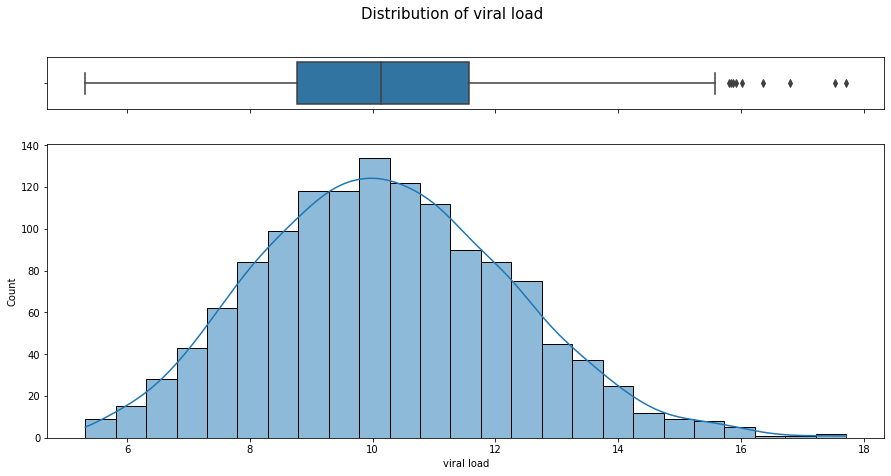

In [39]:
make_numerical_plots(df, 'viral load')

__Findings:__
- There are outliers in the dataset

In [40]:
print(f'The values lying ouside of {quantile_boundaries(df["viral load"])} are considered outliers')
print(f'There are {outlier_count(df["viral load"])} outlier data points')

The values lying ouside of (4.554999999999997, 15.775000000000002) are considered outliers
There are 9 outlier data points


__Findings__
- We will remove the outliers

#### hospitalization charges

In [41]:
df['hospitalization charges'].describe()

count      1338.000000
mean      33176.058296
std       30275.029296
min        2805.000000
25%       11851.000000
50%       23455.000000
75%       41599.500000
max      159426.000000
Name: hospitalization charges, dtype: float64

__Findings:__
- The hospitalization charges ranges from 2805 to 159426
- The mean value is 33176 and median value is 23455

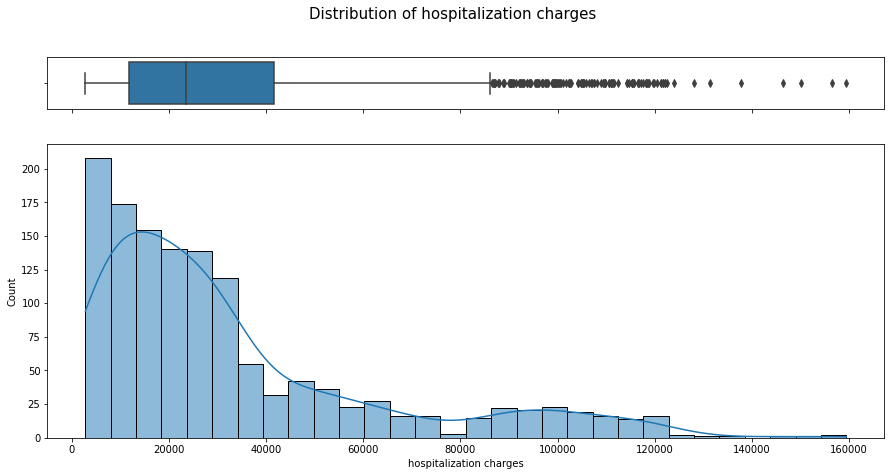

In [42]:
make_numerical_plots(df, 'hospitalization charges')

__Findings:__
- There are some outlier points in the dataset. 


In [43]:
print(f'The values lying ouside of {quantile_boundaries(df["hospitalization charges"])} are considered outliers')
print(f'There are {outlier_count(df["hospitalization charges"])} outlier data points')

The values lying ouside of (-32771.75, 86222.25) are considered outliers
There are 139 outlier data points


## Cleaning the data

Before we move to further analysis, we will remove the outliers that could impact our analysis:

In [44]:
def clean_data(df):

    #1 remove outliers from hospitalization charges
    low, high = quantile_boundaries(df["hospitalization charges"])
    df = df[(df["hospitalization charges"]>=low) & (df["hospitalization charges"]<=high)]
    
    #2 remove outliers from viral load
    low, high = quantile_boundaries(df["viral load"])
    df = df[(df["viral load"]>=low) & (df["viral load"]<=high)]
    
    return df

In [45]:
cleaned_df = clean_data(df)
cleaned_df.shape

(1186, 7)

In [46]:
print(f'Percentage of rows removed = {(len(df) - len(cleaned_df)) / len(df) * 100}')

Percentage of rows removed = 11.360239162929746


## Bivariate Analysis

The dependent variable for our problem statement is "hospitalization charges", and the remaing attribues are the independent variable. We will try to understand the effect of the independent variable on "hospitalization charges" by a conducting range of hypothesis testing. The analyse will help us understand the impact of the variables on the demand of the electric cycles.


### Effect of smoking on hospitalization charges

In [47]:
def bi_cat_plot(df, x, target='hospitalization charges'):
    plt.figure(figsize=(15, 7))
    sns.boxplot(data=df, x=x, y=target)
    plt.title(f'Plot for {x} vs {target}', fontsize=15)
    plt.show()

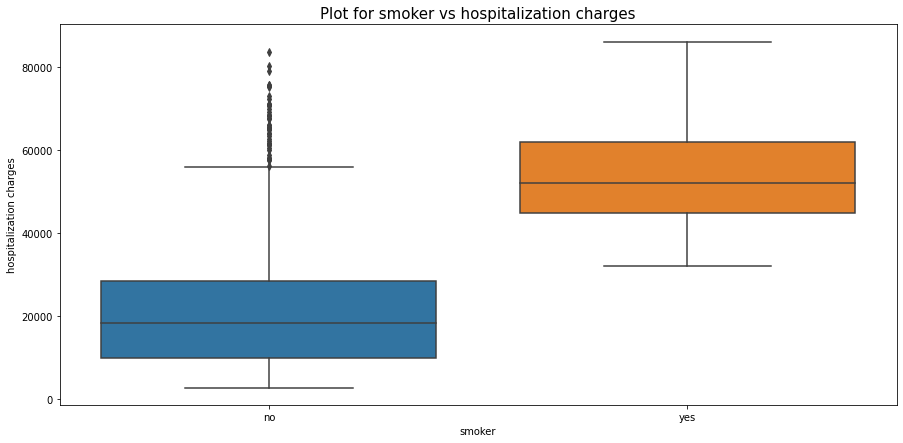

In [48]:
bi_cat_plot(cleaned_df, 'smoker')

In [49]:
cleaned_df.groupby('smoker')['hospitalization charges'].mean()

smoker
no     20924.954198
yes    55035.586957
Name: hospitalization charges, dtype: float64

In [50]:
cleaned_df['smoker'].value_counts()

no     1048
yes     138
Name: smoker, dtype: int64

__Findings__:

- The median and mean hospitalization charges for non-smoker is less than smokers
- There are some outlier points for non-smokers, but as we have already removed the outliers from "hospitalization charges", we won't remove them

However, one thing to note is that, the number of patients for the two groups are not balanced. Hence, these metrics do not convey the real picture. We will set up hypothesis testing to understand if there is any difference in hospitalization charges for the two groups.

__Q Does hospitalization charges of people who do smoking are greater than those who don't??__

- The null hypothesis, Ho: The average hospitalization charges of smokers is less than or equal to non-smokers
- The alternative hypothesis, Ha: The hospitalization charges for smoker is greater than non-smoker

Here, we will be conducting a right-tailed test, with alpha = 0.05

One of the tests that we can use here is t-test. But there are certain assumptions that needs to be fulfilled before proceeding with the test. 

Some of the assumptions of t-test:
- the data, when plotted, results in a normal distribution, bell-shaped distribution curve.
- homogeneity of variance.

#### Normality check


We will perform normality check using Shapiro test.

The hypothesis of this test are:
- Null Hypothesis Ho - series is normal
- Alternative Hypothesis Ha - series is not normal

In [51]:
from scipy.stats import shapiro
def normality_check(series, alpha=0.05):
    _, p_value = shapiro(series)
    print(f'p value = {p_value}')
    if p_value >= alpha:
        print('We fail to reject the Null Hypothesis Ho')
    else:
        print('We reject the Null Hypothesis Ho')

1. Distribution of smoker = 'no

In [52]:
normality_check(cleaned_df[cleaned_df['smoker'] == 'no']['hospitalization charges'])

p value = 2.1157218663148426e-27
We reject the Null Hypothesis Ho


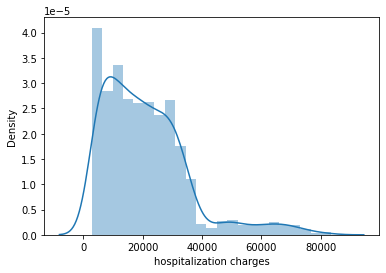

In [53]:
sns.distplot(cleaned_df[cleaned_df['smoker'] == 'no']['hospitalization charges'])

2. Distribution of smoker = yes

In [54]:
normality_check(cleaned_df[cleaned_df['smoker'] == 'yes']['hospitalization charges'])

p value = 1.0100677627633559e-06
We reject the Null Hypothesis Ho


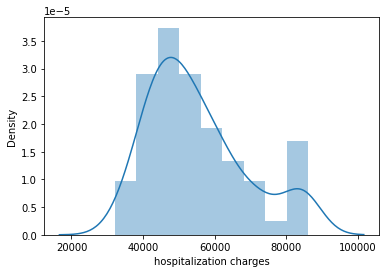

In [55]:
sns.distplot(cleaned_df[cleaned_df['smoker'] == 'yes']['hospitalization charges'])

__Conclusions__
- All the distributions do not pass the normality check

#### Equality of variance check

We will perform equivalence check for using using Levene's test.

The hypothesis of this test are:
- Null Hypothesis Ho - Variances are equal
- Alternative Hypothesis Ha - Variances are not equal

In [56]:
from scipy.stats import levene
def variance_check(series1, series2, alpha=0.05):
    _, p_value = levene(series1, series2)
    print(f'p value = {p_value}')
    if p_value >= alpha:
        print('We fail to reject the Null Hypothesis Ho')
    else:
        print('We reject the Null Hypothesis Ho')

In [57]:
variance_check(cleaned_df[cleaned_df['smoker'] == 'no']['hospitalization charges'], \
               cleaned_df[cleaned_df['smoker'] == 'yes']['hospitalization charges'])

p value = 0.9029719801888336
We fail to reject the Null Hypothesis Ho


__Findings:__
- The distributions have equal variances

__Conclusion__

The distributions fail to satisfy the assumptions of t-test.


Hence, we will use the non-parametric __Mann Whitney test__ to assess whether the hospitalization charges for smokers is greater than non-smokers.

#### Mann Whitnet test

The hypothesis of this test are:
- Null Hypothesis Ho - underlying distribution of both smoker and non-smoker are same 
- Alternative Hypothesis Ha - the distribution underlying smokers is stochastically greater than the distribution underlying non-smokers

We will use alpha = 0.05

In [58]:
from scipy.stats import mannwhitneyu
test, p_val= mannwhitneyu(cleaned_df[cleaned_df['smoker'] == 'yes']['hospitalization charges'], \
                          cleaned_df[cleaned_df['smoker'] == 'no']['hospitalization charges'],
                          alternative='greater')

In [59]:
p_val

3.120319825111216e-67

__Inference__
- We reject the null hypothesis.

The hospitalization charges for smoker is greater than non-smoker.

### Effect of sex on hospitalization charges

In [60]:
def bi_cat_plot(df, x, target='hospitalization charges'):
    plt.figure(figsize=(15, 7))
    sns.boxplot(data=df, x=x, y=target)
    plt.title(f'Plot for {x} vs {target}', fontsize=15)
    plt.show()

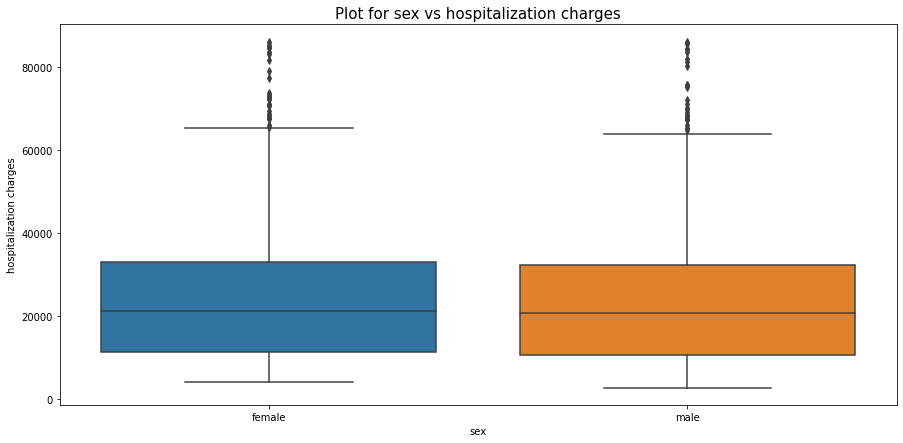

In [61]:
bi_cat_plot(cleaned_df, 'sex')

In [62]:
cleaned_df.groupby('sex')['hospitalization charges'].mean()

sex
female    25239.906250
male      24530.103806
Name: hospitalization charges, dtype: float64

In [63]:
cleaned_df['sex'].value_counts()

female    608
male      578
Name: sex, dtype: int64

__Findings__:

- The median and mean hospitalization charges for both male and female are nearly same
- There are some outlier points for both male and female, but as we have already removed the outliers from "hospitalization charges", we won't remove them

In [64]:
cleaned_df.groupby(['sex', 'smoker'])['hospitalization charges'].mean().unstack()

smoker,no,yes
sex,,
female,21487.092593,55041.661765
male,20327.405512,55029.685714


__Findings__
- Females who do not smoke have higher mean hospitalization charges as compared to its male counterpart. This could be because of child birth, or pregnancy related diagnosis.


### Effect of region on hospitalization charges

In [65]:
def bi_cat_plot(df, x, target='hospitalization charges'):
    plt.figure(figsize=(15, 7))
    sns.boxplot(data=df, x=x, y=target)
    plt.title(f'Plot for {x} vs {target}', fontsize=15)
    plt.show()

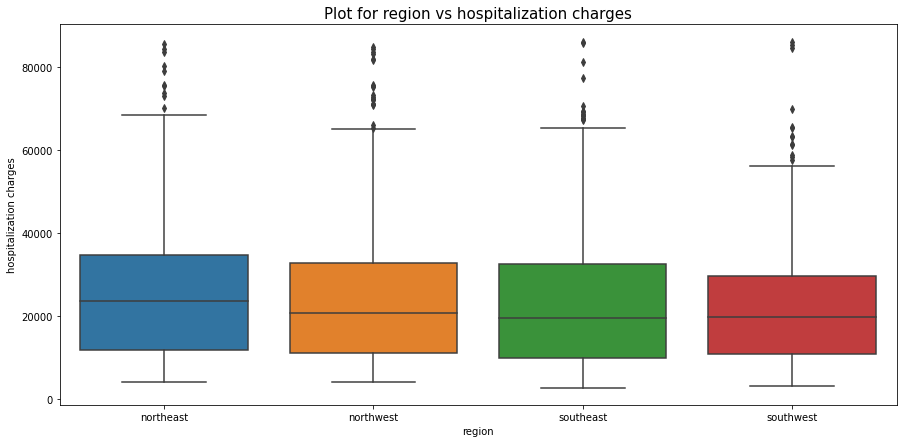

In [66]:
bi_cat_plot(cleaned_df, 'region')

In [67]:
cleaned_df.groupby('region')['hospitalization charges'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
northeast,295.0,26851.705085,18311.869527,4237.0,11797.5,23618.0,34653.0,85635.0
northwest,305.0,25908.986885,19318.451598,4053.0,11157.0,20777.0,32782.0,84769.0
southeast,297.0,24160.764310,18697.074793,2805.0,9869.0,19510.0,32453.0,86100.0
southwest,289.0,22577.930796,15833.388533,3104.0,10979.0,19886.0,29593.0,86182.0


__Findings__:

- The mean hospitalization charges is highest in the northeast region, and lowest in the southwest region
- The median hospitalization charges is highest in the northeast region, and lowest in the southeast region
- There are some outlier points in all the regions, but as we have already removed the outliers from "hospitalization charges", we won't remove them

### Effect of severity level on hospitalization charges

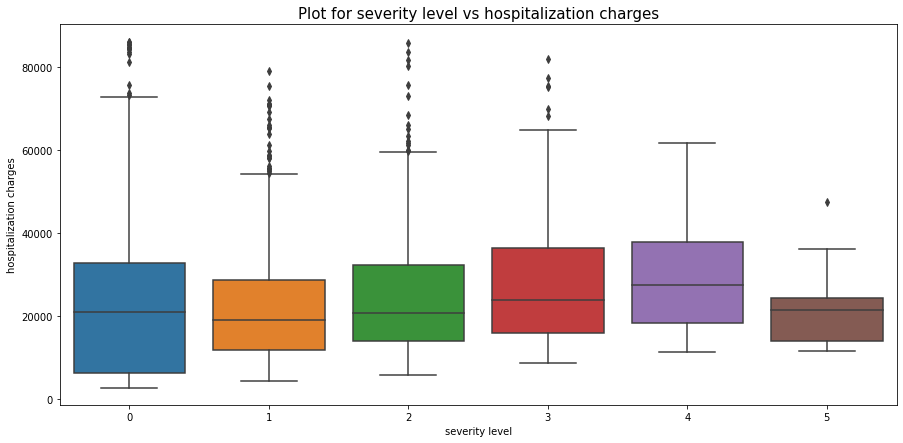

In [68]:
bi_cat_plot(cleaned_df, 'severity level')

In [69]:
cleaned_df.groupby('severity level')['hospitalization charges'].describe()

,count,mean,std,min,25%,50%,75%,max
severity level,,,,,,,,
0,520.0,23629.713462,19361.662096,2805.0,6245.25,21109.0,32897.75,86182.0
1,287.0,23839.693380,16892.402945,4278.0,11822.50,19067.0,28833.50,79050.0
2,202.0,26695.589109,17776.754857,5760.0,14051.50,20766.5,32254.75,85758.0
3,137.0,28939.138686,17304.304348,8608.0,15902.00,23908.0,36477.00,81969.0
4,23.0,29293.913043,14000.406335,11262.0,18445.50,27538.0,37779.00,61679.0
5,17.0,21405.235294,9503.863389,11719.0,14038.00,21456.0,24472.00,47558.0


__Findings__:

- The average hospitalization charges increases as the severity level increases
- The count of patients with severity level 0 is highest, and lowest for severity level 5. Meaning, less severe conditions are quite common, and as the severity level increases, people getting affected by it also decreases.

### Effect of age and viral load on hospitalization charges

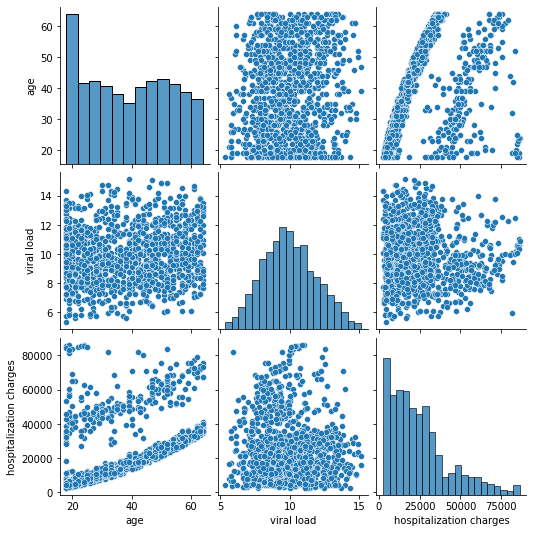

In [70]:
sns.pairplot(cleaned_df)
plt.show()

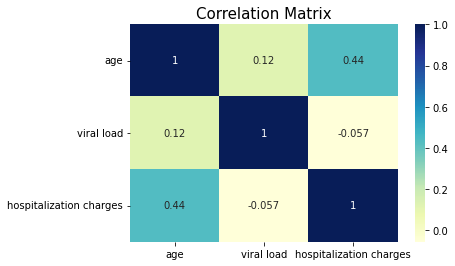

In [71]:
# plotting correlation heatmap
dataplot = sns.heatmap(cleaned_df.corr(), cmap="YlGnBu", annot=True)
plt.title('Correlation Matrix', fontsize=15);
# displaying heatmap
plt.show()

__Findings:__
- As age increase, the hospitalization charges also increases

### Deep dive into Age

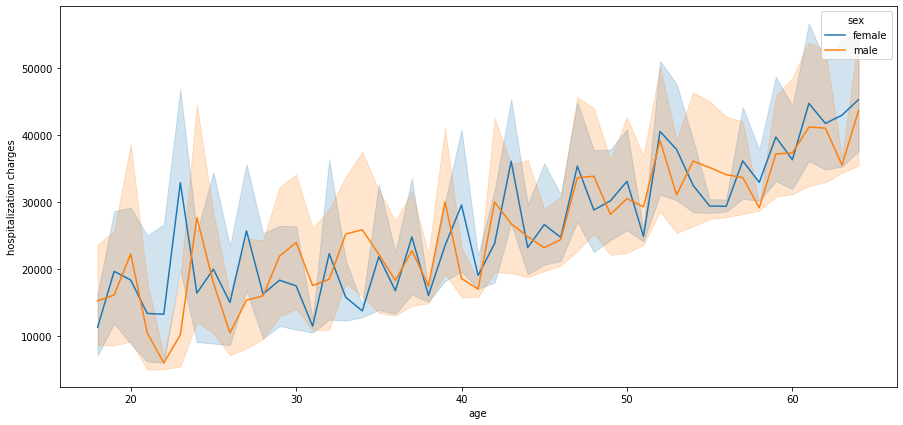

In [72]:
cleaned_df['age bins'] = pd.cut(x=df['age'], bins=[0,18,28,38,48,58,68,100],
                                labels=['0-18', '18-28', '28-38', '38-48', '48-58','58-68', '68-100'])

plt.figure(figsize=(15, 7))
sns.lineplot(x='age', y='hospitalization charges', data=cleaned_df, hue='sex')
plt.show()

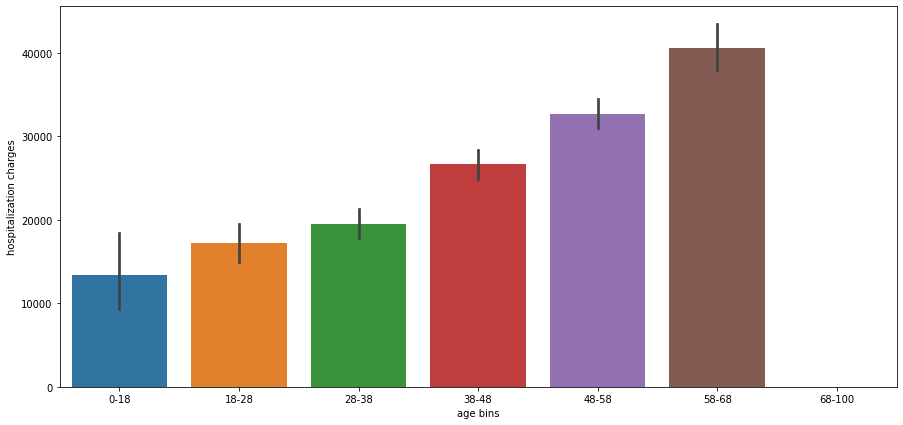

In [73]:
plt.figure(figsize=(15, 7))
sns.barplot(x='age bins', y='hospitalization charges', data=cleaned_df)
plt.show()

__Findings__
- As expected, as the age increases, the hospitalization charges also increases

### Effect of sex on viral laod

In [74]:
def bi_cat_plot(df, x, target='hospitalization charges'):
    plt.figure(figsize=(15, 7))
    sns.boxplot(data=df, x=x, y=target)
    plt.title(f'Plot for {x} vs {target}', fontsize=15)
    plt.show()

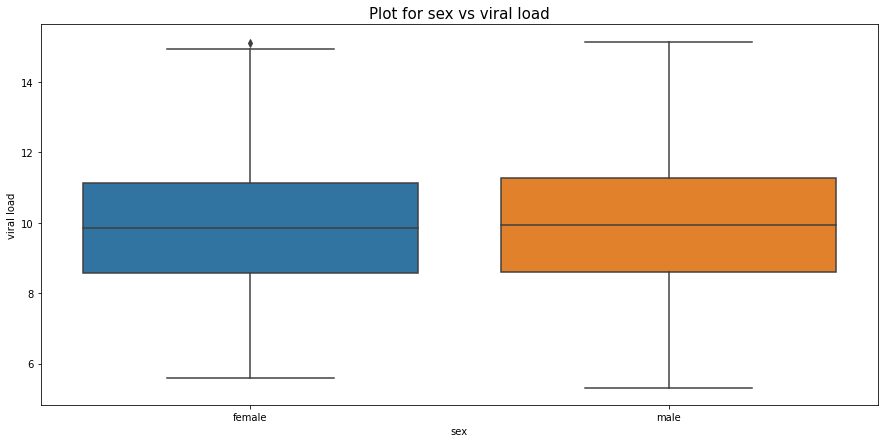

In [75]:
bi_cat_plot(cleaned_df, 'sex', 'viral load')

In [76]:
cleaned_df.groupby('sex')['viral load'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,608.0,9.940987,1.934166,5.60,8.58,9.84,11.1350,15.11
male,578.0,9.994896,1.896921,5.32,8.60,9.93,11.2675,15.14


__Findings__:

- The median and mean viral load is nearly the same for both male and females
- There are some outlier points for females, but as we have already removed the outliers from "viral load", we won't remove them

__Q Is the viral load of females is different from that of males??__

- The null hypothesis, Ho: The viral load of females and males are same
- The alternative hypothesis, Ha: The viral load of females and males are different

One of the tests that we can use here is 2 tailed t-test. But there are certain assumptions that needs to be fulfilled before proceeding with the test. 

Some of the assumptions of 2 tailed t-test:
- the data, when plotted, results in a normal distribution, bell-shaped distribution curve.
- homogeneity of variance.

#### Normality check


We will perform normality check using Shapiro test.

The hypothesis of this test are:
- Null Hypothesis Ho - series is normal
- Alternative Hypothesis Ha - series is not normal

In [77]:
from scipy.stats import shapiro
def normality_check(series, alpha=0.05):
    _, p_value = shapiro(series)
    print(f'p value = {p_value}')
    if p_value >= alpha:
        print('We fail to reject the Null Hypothesis Ho')
    else:
        print('We reject the Null Hypothesis Ho')

1. Distribution of viral load for females

In [78]:
normality_check(cleaned_df[cleaned_df['sex'] == 'female']['viral load'])

p value = 0.0019581581000238657
We reject the Null Hypothesis Ho


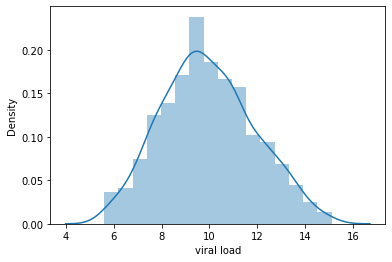

In [79]:
sns.distplot(cleaned_df[cleaned_df['sex'] == 'female']['viral load'])

2. Distribution of viral load for males

In [80]:
normality_check(cleaned_df[cleaned_df['sex'] == 'male']['viral load'])

p value = 0.023935377597808838
We reject the Null Hypothesis Ho


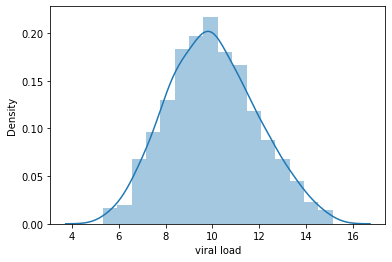

In [81]:
sns.distplot(cleaned_df[cleaned_df['sex'] == 'male']['viral load'])

__Conclusions__
- All the distributions do not pass the normality check

#### Equality of variance check

We will perform equivalence check for using using Levene's test.

The hypothesis of this test are:
- Null Hypothesis Ho - Variances are equal
- Alternative Hypothesis Ha - Variances are not equal

In [82]:
from scipy.stats import levene
def variance_check(series1, series2, alpha=0.05):
    _, p_value = levene(series1, series2)
    print(f'p value = {p_value}')
    if p_value >= alpha:
        print('We fail to reject the Null Hypothesis Ho')
    else:
        print('We reject the Null Hypothesis Ho')

In [83]:
variance_check(cleaned_df[cleaned_df['sex'] == 'male']['viral load'], \
               cleaned_df[cleaned_df['sex'] == 'female']['viral load'])

p value = 0.5603347156290578
We fail to reject the Null Hypothesis Ho


__Findings:__
- The distributions have equal variances

__Conclusion__

The distributions fail to satisfy the assumptions of t-test. 
Hence, we will use the non-parametric __Mann Whitney test__ to assess whether there is a statistically significant difference in the viral load for males and females

#### Mann Whitnet test

The hypothesis of this test are:
- Null Hypothesis Ho - underlying distribution of male viral load and female viral load are same
- Alternative Hypothesis Ha - underlying distribution of male viral load and female viral load are not same

We will use alpha = 0.05

In [84]:
from scipy.stats import mannwhitneyu
test, p_val= mannwhitneyu(cleaned_df[cleaned_df['sex'] == 'male']['viral load'], \
                          cleaned_df[cleaned_df['sex'] == 'female']['viral load'],)

In [85]:
if p_val >= 0.05:
    print('We fail to reject the Null Hypothesis Ho')
else:
    print('We reject the Null Hypothesis Ho')

We fail to reject the Null Hypothesis Ho


__Inference__
- We fail to reject the null hypothesis.

The viral fever for male and female are not different

### Effect of smoking on regions

In [86]:
contigency_smoking_region = pd.crosstab(df.region, df.smoker)
contigency_smoking_region

smoker,no,yes
region,,
northeast,257,67
northwest,267,58
southeast,273,91
southwest,267,58


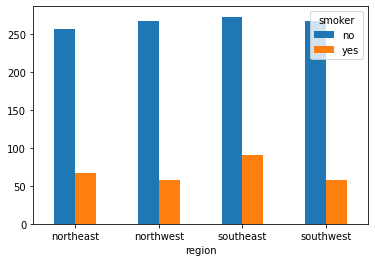

In [115]:
contigency_smoking_region.plot(kind="bar", stacked=False, rot=0)
plt.show()

__Q Is the proportion of smoking significantly different across different regions?__

- The null hypothesis, Ho: There is no difference in the proportion of smoking in different regions
- The alternative hypothesis, Ha: There is difference in the proportion of smoking in different regions

Here, we will be conducting a test, with alpha = 0.05

One of the tests that we can use here is chi-square test. 

In [87]:
from scipy.stats import chi2_contingency

chi2, pval, dof, exp_freq = chi2_contingency(contigency_smoking_region, correction=False)
print(pval)

0.06171954839170541


In [88]:
if pval >= 0.05:
    print('We fail to reject the Null Hypothesis Ho')
else:
    print('We reject the Null Hypothesis Ho')

We fail to reject the Null Hypothesis Ho


__Findings__
- There is no difference in the proportion of smoking in different regions

### Effect of severity level on women

In [139]:
tmp = cleaned_df[(cleaned_df['severity level'] == 0) |
                 (cleaned_df['severity level'] == 1) | 
                 (cleaned_df['severity level'] == 2) ]
tmp['severity level'].value_counts()

0    520
1    287
2    202
3      0
4      0
5      0
Name: severity level, dtype: int64

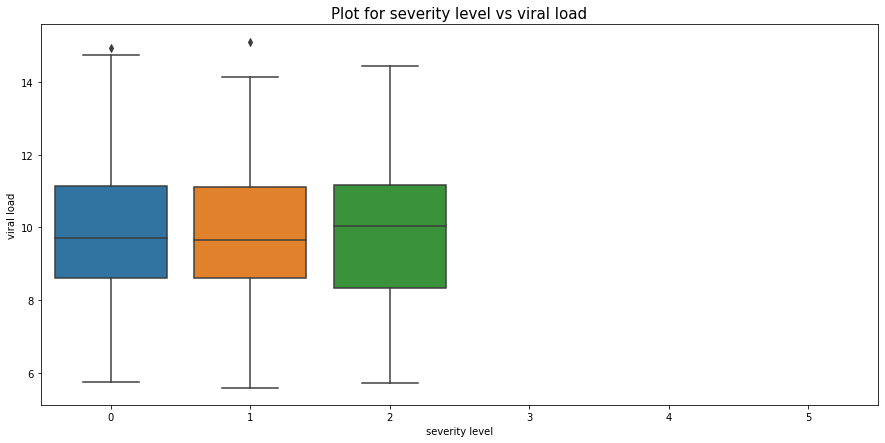

In [140]:
bi_cat_plot(tmp[tmp['sex']=='female'], 'severity level', 'viral load')

In [141]:
cleaned_df[cleaned_df['sex']=='female'].groupby('severity level')['viral load'].describe().head(3)

,count,mean,std,min,25%,50%,75%,max
severity level,,,,,,,,
0,269.0,9.967212,1.934359,5.76,8.61,9.700,11.1300,14.92
1,146.0,9.871507,1.871249,5.60,8.60,9.655,11.1025,15.11
2,105.0,9.891429,2.027979,5.73,8.33,10.050,11.1800,14.45


__Findings:__
- The mean viral load for women with 0 Severity level, 1 Severity level, and 2 Severity level looks the same.

However, we will perform a hypothesis testing to back our claim.

__Q Is the mean viral load of women with 0 Severity level, 1 Severity level, and 2 Severity level the same??__

- The null hypothesis, Ho: The mean viral load of women with no severity level, 1 severity level, and 2 severity level are same
- The alternative hypothesis, Ha: Atleast one of mean viral load of women is not same.

Here, we will be conducting a test, with alpha = 0.05

One of the tests that we can use here is one way ANOVA. But there are certain assumptions that needs to be fulfilled before proceeding with the test. 

Some of the assumptions of one way ANOVA:
- the data, when plotted, results in a normal distribution, bell-shaped distribution curve.
- homogeneity of variance.

#### Normality check


We will perform normality check using Shapiro test.

The hypothesis of this test are:
- Null Hypothesis Ho - series is normal
- Alternative Hypothesis Ha - series is not normal

1. Distribution of viral load (women) for severity level 0

In [121]:
normality_check(cleaned_df[(cleaned_df['severity level'] == 0) & (cleaned_df['sex']=='female')]['viral load'])

p value = 0.010587471537292004
We reject the Null Hypothesis Ho


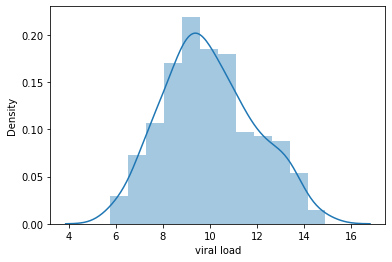

In [122]:
sns.distplot(cleaned_df[(cleaned_df['severity level'] == 0) & (cleaned_df['sex']=='female')]['viral load'])

2. Distribution of viral load (women) for severity level 1

In [124]:
normality_check(cleaned_df[(cleaned_df['severity level'] == 1) & (cleaned_df['sex']=='female')]['viral load'])

p value = 0.592917799949646
We fail to reject the Null Hypothesis Ho


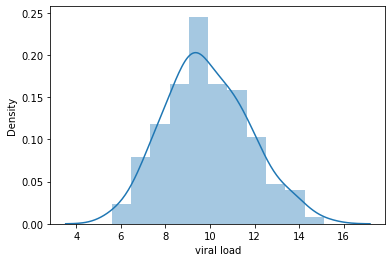

In [125]:
sns.distplot(cleaned_df[(cleaned_df['severity level'] == 1) & (cleaned_df['sex']=='female')]['viral load'])

3. Distribution of viral load (women) for severity level 2

In [126]:
normality_check(cleaned_df[(cleaned_df['severity level'] == 2) & (cleaned_df['sex']=='female')]['viral load'])

p value = 0.30996617674827576
We fail to reject the Null Hypothesis Ho


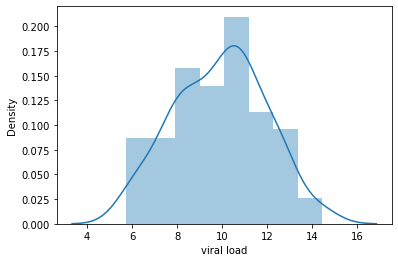

In [127]:
sns.distplot(cleaned_df[(cleaned_df['severity level'] == 2) & (cleaned_df['sex']=='female')]['viral load'])

__Conclusions__
- All the distributions do not pass the normality check

#### Equality of variance check

In [95]:
cleaned_df[cleaned_df['sex']=='female'].groupby('severity level')['viral load'].describe().head(3)

,count,mean,std,min,25%,50%,75%,max
severity level,,,,,,,,
0,269.0,9.967212,1.934359,5.76,8.61,9.700,11.1300,14.92
1,146.0,9.871507,1.871249,5.60,8.60,9.655,11.1025,15.11
2,105.0,9.891429,2.027979,5.73,8.33,10.050,11.1800,14.45


__Findings:__
- The mean viral load for women with severity level 0, 1, and 2 are same. However we will conduct hypothesis testing to back our claim

We will perform equivalence check for using using Levene's test.

The hypothesis of this test are:
- Null Hypothesis Ho - Variances are equal
- Alternative Hypothesis Ha - Variances are not equal

In [96]:
from scipy.stats import levene
def variance_check(series1, series2, series3, alpha=0.05):
    _, p_value = levene(series1, series2, series3)
    print(f'p value = {p_value}')
    if p_value >= alpha:
        print('We fail to reject the Null Hypothesis Ho')
    else:
        print('We reject the Null Hypothesis Ho')

In [128]:
variance_check(cleaned_df[(cleaned_df['severity level'] == 0) & (cleaned_df['sex']=='female')]['viral load'], \
               cleaned_df[(cleaned_df['severity level'] == 1) & (cleaned_df['sex']=='female')]['viral load'], \
               cleaned_df[(cleaned_df['severity level'] == 2) & (cleaned_df['sex']=='female')]['viral load'])

p value = 0.5752767548738419
We fail to reject the Null Hypothesis Ho


__Findings:__
- The variances are almost equal

__Conclusion__

As ANOVA is not very sensitive to moderate deviations from normality, we will continue using ANOVA for the hypothesis testing.

#### ANOVA test

The hypothesis of this test are:
- Null Hypothesis Ho - the mean viral load of women with severity level 0, 1, and 2 is same
- Alternative Hypothesis Ha - Atleast one of the mean viral load for women with severity level 0, 1, and 2 are not same

We will use alpha = 0.05 for the test.

In [129]:
from scipy.stats import f_oneway
test, p_val= f_oneway(cleaned_df[cleaned_df['severity level'] == 0]['viral load'], \
                      cleaned_df[cleaned_df['severity level'] == 1]['viral load'], \
                      cleaned_df[cleaned_df['severity level'] == 2]['viral load'])

In [130]:
if p_val >= 0.05:
    print('We fail to reject the Null Hypothesis Ho')
else:
    print('We reject the Null Hypothesis Ho')

We fail to reject the Null Hypothesis Ho


__Inference__
- We fail to reject the null hypothesis.

The avg viral load of women with 0 Severity level, 1 Severity level, and 2 Severity level are the same.